In [17]:
# 필요한 라이브러리 import
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [18]:
# 오토인코더 모델 클래스 생성
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    # 인코더
    self.encoder = nn.Sequential(
      nn.Linear(28*28, 128),
      nn.Tanh(),
      nn.Linear(128, 64),
      nn.Tanh(),
      nn.Linear(64, 12),
      nn.Tanh(),
      nn.Linear(12,3) # latent space
    )
    # 디코더
    self.decoder = nn.Sequential(
      nn.Linear(3, 12),
      nn.Tanh(),
      nn.Linear(12, 64),
      nn.Tanh(),
      nn.Linear(64, 128),
      nn.Tanh(),
      nn.Linear(128, 28*28),
      nn.Sigmoid()    # output 0~1
    )
  # 순전파
  def forward(self, x):
    x_encoded = self.encoder(x)
    x = self.decoder(x_encoded)
    return x, x_encoded

In [19]:
# 데이터변환
transform = transforms.Compose([
  transforms.ToTensor(),
])

# 학습데이터 로드 Load the train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 테스트 데이터 로드
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [23]:
# 첫 번째 Iteration에서 나오는 데이터 확인
# tensorflow에서는  (batch_size, height, width, channel) - (32, 28, 28, 1)
# pytorch에서는  (batch_size, channel, height, width) - (32, 1, 28, 28)
# rgb였으면 1이 아니라 3
# pytorch와 tensorflow의 차이점 !!

images, labels = next(iter(train_loader))
images.shape

torch.Size([32, 1, 28, 28])

In [21]:
# 모델 초기화, 손실함수, 옵티마이저  Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [27]:
# 학습 Training loop
# pytorch에서 불러오는 MNIST 데이터의 경우 [1, 28, 28]로 구성된다.
num_epochs = 20
for epoch in range(num_epochs):
  for data in train_loader:
    img, _ = data  
    img = img.view(img.size(0), -1) # 1차원 즉, 784로 바꿔주고, 실제로는 (32, 784) <--  (batch_size, 1, 28. 28)
    output, _ = model(img)           # x, encoded_x
    loss = criterion(output, img)
    
    optimizer.zero_grad()
    loss.backward()   # gradient 계산
    optimizer.step()  # weight, bias update
  
  print(f'Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}')

print("Training Complete")

Epoch [1/20], loss: 0.0559
Epoch [2/20], loss: 0.0413
Epoch [3/20], loss: 0.0464
Epoch [4/20], loss: 0.0457
Epoch [5/20], loss: 0.0397
Epoch [6/20], loss: 0.0316
Epoch [7/20], loss: 0.0347
Epoch [8/20], loss: 0.0365
Epoch [9/20], loss: 0.0318
Epoch [10/20], loss: 0.0377
Epoch [11/20], loss: 0.0338
Epoch [12/20], loss: 0.0332
Epoch [13/20], loss: 0.0300
Epoch [14/20], loss: 0.0350
Epoch [15/20], loss: 0.0335
Epoch [16/20], loss: 0.0326
Epoch [17/20], loss: 0.0344
Epoch [18/20], loss: 0.0308
Epoch [19/20], loss: 0.0351
Epoch [20/20], loss: 0.0279
Training Complete


In [28]:
# 모델 테스트 Testing the model and visualizing some results
# 테스트 데이터
dataiter = iter(test_loader)
images, _ = next(dataiter)
images_falttened = images.view(images.size(0), -1)
images_falttened.shape


torch.Size([1000, 784])

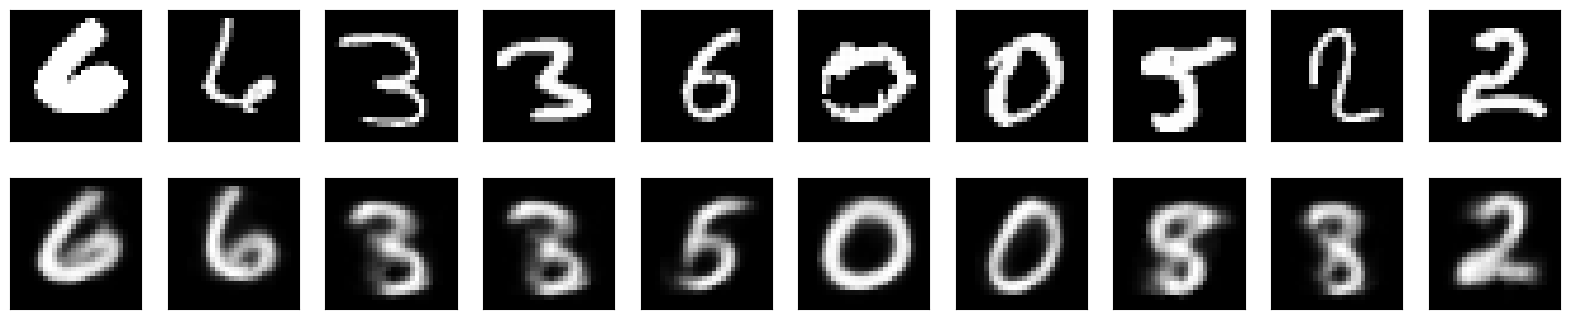

In [29]:
# 테스트 이미지 순전파 forward pass through the autoencoder
output, _ = model(images_falttened)
output = output.view(output.size(0), 1, 28, 28).detach()

# 테스트 이미지 결과 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

# 테스트 이미지와 결과 이미지
for images, row in zip([images, output], axes):
  for img, ax in zip(images, row):
    ax.imshow(img.squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

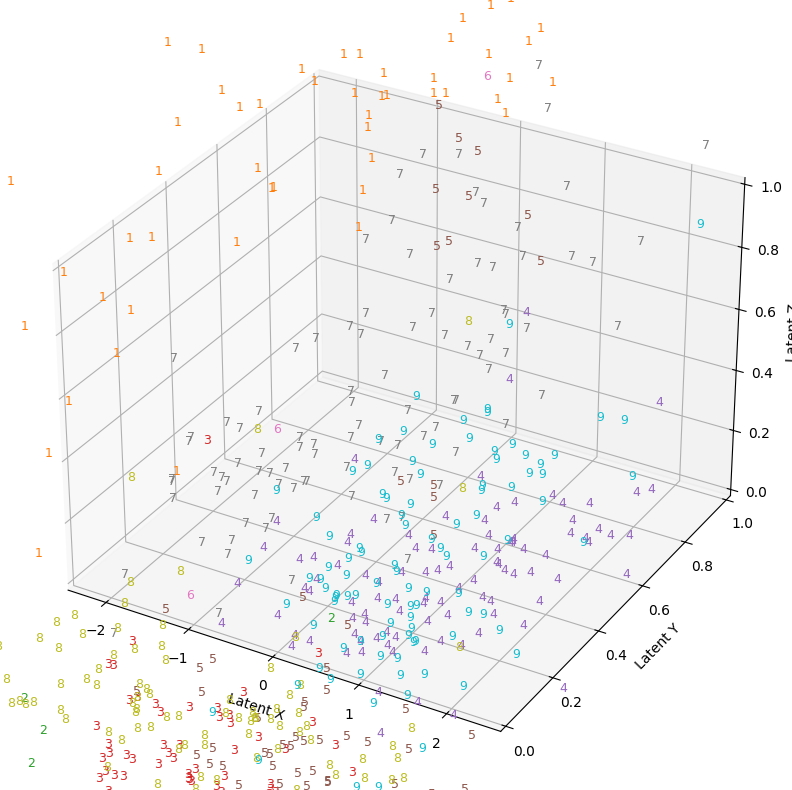

In [30]:
# 모델의 잠재공간 시각화
model.eval()  # Set the model to evaluation mode

latent_vector = []
labels = []

with torch.no_grad():
  for data in test_loader:
    imgs, lbls = data
    imgs = imgs.view(imgs.size(0), -1)
    _, latents = model(imgs)
    latent_vector.append(latents)
    labels.append(lbls)

latent_vectors = torch.cat(latent_vector, dim=0)
labels = torch.cat(labels, dim=0)

# 3d 시각화
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# 각각의 잠재공간 좌표점들을 라벨과 색깔로 표현
for i in range(10):
  indices = np.where(labels == i)[0]
  subset_indices = np.random.choice(indices, size=min(len(indices), 100), replace=False)

  for idx in subset_indices:
    ax.text(latent_vectors[idx, 0].item(), latent_vectors[idx, 1].item(), latent_vectors[idx, 2].item(),
            str(i), color=plt.cm.tab10(i), fontsize=9, ha='center')
    
# 각 좌표축의 길이를 설정
x_min, x_max = latent_vectors[:,0].min(), latent_vectors[:,0].max()
y_min, y_max = latent_vectors[:,1].min(), latent_vectors[:,1].max()
z_min, z_max = latent_vectors[:,2].min(), latent_vectors[:,2].max()

ax.set_xlim(x_min, x_max)
ax.set_xlim(y_min, y_max)
ax.set_xlim(z_min, z_max)

ax.set_xlabel('Latent X')
ax.set_ylabel('Latent Y')
ax.set_zlabel('Latent Z')

plt.show()


